https://www.coursera.org/learn/supervised-learning/lecture/Ornvu/zadacha-bike-sharing-demand-prodolzhieniie

**Корректность проверена на Python 3.6:**
+ pandas 0.23.4
+ numpy 1.15.4
+ sklearn 0.20.2

In [1]:
import warnings
warnings.filterwarnings('ignore')

# Sklearn

## Bike Sharing Demand
Задача на kaggle: https://www.kaggle.com/c/bike-sharing-demand

По историческим данным о прокате велосипедов и погодных условиях необходимо спрогнозировтаь спрос на прокат велосипедов.

В исходной постановке задачи доступно 11 признаков: https://www.kaggle.com/c/prudential-life-insurance-assessment/data

В наборе признаков присутсвуют вещественные, категориальные, и бинарные данные. 

Для демонстрации используется обучающая выборка из исходных данных train.csv, файлы для работы прилагаются.

### Библиотеки

In [11]:
from sklearn import model_selection, linear_model, metrics, pipeline, preprocessing

import numpy as np
import pandas as pd

In [12]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Загрузка данных

In [13]:
raw_data = pd.read_csv('bike_sharing_demand.csv', header = 0, sep = ',')

In [14]:
raw_data.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [15]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


### Предобработка данных

#### Обучение и отложенный тест

In [16]:
# преобразуем столбец datetime в тип datetime; сейчас это строковый тип
raw_data.datetime = raw_data.datetime.apply(pd.to_datetime)

In [17]:
# добавим 2 столбца с месяцем и часом
raw_data['month'] = raw_data.datetime.apply(lambda x : x.month)
raw_data['hour'] = raw_data.datetime.apply(lambda x : x.hour)

In [18]:
# разобъём выборку на обучающую и тестовую
train_data = raw_data.iloc[:-1000, :]
hold_out_test_data = raw_data.iloc[-1000:, :]

In [19]:
# поссмотрим размеры выборок
print(raw_data.shape, train_data.shape, hold_out_test_data.shape)

(10886, 14) (9886, 14) (1000, 14)


In [20]:
#обучение
# отделим целевую перменную от признаков и уберем лишние признаки
train_labels = train_data['count'].values
train_data = train_data.drop(['datetime', 'count', 'casual', 'registered'], axis = 1)

In [21]:
#тест
# отделим целевую перменную от признаков и уберем лишние признаки
test_labels = hold_out_test_data['count'].values
test_data = hold_out_test_data.drop(['datetime', 'count', 'casual', 'registered'], axis = 1)

In [22]:
# хотим получить индекс, который будет принимать значение true в позиции нужных столбцов.
# Признаки принимают значения 0 или 1, соответственно, если данные являются выходным,
# то первый признак принимает значение 1, в противоположном случае — 0.
# И если день является рабочим, то второй признак принимает значение 1, в противоположном случае — 0.

binary_data_columns = ['holiday', 'workingday']
binary_data_indices = np.array([(column in binary_data_columns) for column in train_data.columns], dtype = bool)

In [23]:
print(binary_data_columns)
print(binary_data_indices)

['holiday', 'workingday']
[False  True  True False False False False False False False]


In [25]:
categorical_data_columns = ['season', 'weather', 'month'] 
categorical_data_indices = np.array([(column in categorical_data_columns) for column in train_data.columns], dtype = bool)

In [26]:
print(categorical_data_columns)
print(categorical_data_indices)

['season', 'weather', 'month']
[ True False False  True False False False False  True False]


In [27]:
# Аналогичные расчеты давайте сделаем для категориальных признаков.
numeric_data_columns = ['temp', 'atemp', 'humidity', 'windspeed', 'hour']
numeric_data_indices = np.array([(column in numeric_data_columns) for column in train_data.columns], dtype = bool)

In [28]:
print(numeric_data_columns)
print(numeric_data_indices)

['temp', 'atemp', 'humidity', 'windspeed', 'hour']
[False False False False  True  True  True  True False  True]


### Pipeline

давайте строить цепочку преобразований, в результате которой мы получим dataset, состоящий из обработанных данных. Сначала давайте создадим модель, которую мы хотим применять — это снова будет регрессия SGD. Сразу же укажем некоторые параметры, которые мы подобрали в прошлый раз. 

In [29]:
regressor = linear_model.SGDRegressor(random_state = 0, n_iter_no_change = 3, loss = 'squared_loss', penalty = 'l2')

Преобразование снова состоит из двух больших шагов: 
1. обработка данных; 
2. построение модели. 

Сначала посмотрим на построение модели, оно не отличается — здесь мы задаем имя шага и передаем нашу модель, наш регрессор. Теперь давайте разберемся с преобразованием данных. Для того чтобы по-разному обрабатывать разные части dataset, разные столбцы из набора данных, нам нужно сначала данные разбить, получить три набора данных. Далее нужно каждый из них обработать по отдельности и дальше собрать их вместе. Причем собирать их каждый раз нужно в одинаковом порядке — это важно, потому что фактически мы можем использовать это преобразование для кросс-валидации, для подбора параметров, поэтому нам действительно нужно получать каждый раз набор данных в заданном порядке.

Для того чтобы сначала разделить данные на несколько частей, а потом собрать их вместе, нам нужна функциональность `FeatureUnion` — это некоторый трансформер, который ровно это и делает.

Первое преобразование — работа с бинарными данными, второе преобразование — работа с численными данными, и последнее преобразование — работа с категориальными данными. Это и есть наш transformer list — список преобразований. 

1. Бинарные данные устраивают нас в таком виде, в котором они уже есть, мы не хотим никак их изменять. Просто используем FunctionTransformer, которому мы передаем наш логический индекс — логический индекс, соответствующий бинарным признакам, и говорим, что нам достаточно просто эти данные выбрать, отделить их от всего dataset и, не изменяя, положить их отдельно.
2. Следующий тип данных — эти числовые признаки. Здесь нам придется применить целую цепочку преобразований, потому что фактически их два. Сначала эти данные нужно отделить от остальных, потом нужно их отмасштабировать с помощью scaler. В данном случае нам придется объявить внутри Pipeline, в отличие от предыдущего случая, но это также несложно. Объявляем Pipeline и говорим, что он состоит из двух шагов:
    * первый шаг — это трансформер, то есть фактически мы передаем сюда логический индекс для числовых данных и отделяем их от всех остальных. 
    * И дальше к данным, которые мы отделили, мы применяем scaling — делаем масштабирование. На этом преобразование числовых признаков заканчивается.
3. Последний тип признаков, с которыми мы работаем — это категориальные данные. Здесь также будет цепочка преобразований, поэтому создаем Pipeline. Шаги следующие:
    * первый шаг — это отделение этих данных, то есть фактически мы передаем сюда логический индекс для категориальных признаков и отделяем нужную часть набора данных.
    * И дальше применяем методику hot encoding — помните, что если у нас есть категориальный признак, внутри которого доступно несколько значений, то после кодирования hot encoding мы получаем n признаков, каждый из которых является бинарным. Фактически он, каждый из новых признаков, соответствует отдельному значению старого категориального признака — принимает значение 1 на тех объектах, где достигается это значение, и 0 на всех остальных. Вот ровно такое преобразование мы здесь и применяем.
    
На этом наша цепочка преобразований заканчивается, и последнее, что нужно сделать — это собрать данные вместе и применить второй шаг, обучить модель. 

In [34]:
estimator = pipeline.Pipeline(steps = [       
    ('feature_processing', pipeline.FeatureUnion(transformer_list = [        
            #binary
            ('binary_variables_processing', preprocessing.FunctionTransformer(lambda data: data.iloc[:, binary_data_indices])), 
                    
            #numeric
            ('numeric_variables_processing', pipeline.Pipeline(steps = [
                ('selecting', preprocessing.FunctionTransformer(lambda data: data.iloc[:, numeric_data_indices])),
                ('scaling', preprocessing.StandardScaler(with_mean = 0))            
                        ])),
        
            #categorical
            ('categorical_variables_processing', pipeline.Pipeline(steps = [
                ('selecting', preprocessing.FunctionTransformer(lambda data: data.iloc[:, categorical_data_indices])),
                ('hot_encoding', preprocessing.OneHotEncoder(handle_unknown = 'ignore'))            
                        ])),
        ])),
    ('model_fitting', regressor)
    ]
)

In [35]:
estimator.fit(train_data, train_labels)

Pipeline(steps=[('feature_processing',
                 FeatureUnion(transformer_list=[('binary_variables_processing',
                                                 FunctionTransformer(func=<function <lambda> at 0x0000013EE83FACA0>)),
                                                ('numeric_variables_processing',
                                                 Pipeline(steps=[('selecting',
                                                                  FunctionTransformer(func=<function <lambda> at 0x0000013EE83FAEE0>)),
                                                                 ('scaling',
                                                                  StandardScaler(with_mean=0))])),
                                                ('categorical_variables_processing',
                                                 Pipeline(steps=[('selecting',
                                                                  FunctionTransformer(func=<function <lambda> at 0x0000013EE83

In [36]:
metrics.mean_absolute_error(test_labels, estimator.predict(test_data))

124.67230746253693

теперь оцениваем качество. Вот получаем, что мы ошибаемся на 120 велосипедах — приблизительно то же самое, что и раньше. То есть фактически преобразование данных не помогло нам принципиально улучшить модель. 

### Подбор параметров

Давайте посмотрим, как в случае такой сложной цепочки обращаться к параметрам. Делаем это с помощью комбинации методов get_params и keys. И видим, что да, но не очень удобно, потому что нужно использовать расширенные имена, нужно указывать имя шага, потом имена всех промежуточных шагов и так вплоть до параметра. 

Не будем перебирать слишком много параметров, а для того чтобы ускорить процесс, переберем только два: это коэффициенты alpha и eta0. Создадим такой словарь. И теперь давайте снова воспользуемся поиском по сетке, будем делать полный перебор. Метрика, которую мы оцениваем — это средняя ошибка. И делаем кросс-валидацию на четыре фолда. 

In [37]:
estimator.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'feature_processing', 'model_fitting', 'feature_processing__n_jobs', 'feature_processing__transformer_list', 'feature_processing__transformer_weights', 'feature_processing__verbose', 'feature_processing__binary_variables_processing', 'feature_processing__numeric_variables_processing', 'feature_processing__categorical_variables_processing', 'feature_processing__binary_variables_processing__accept_sparse', 'feature_processing__binary_variables_processing__check_inverse', 'feature_processing__binary_variables_processing__func', 'feature_processing__binary_variables_processing__inv_kw_args', 'feature_processing__binary_variables_processing__inverse_func', 'feature_processing__binary_variables_processing__kw_args', 'feature_processing__binary_variables_processing__validate', 'feature_processing__numeric_variables_processing__memory', 'feature_processing__numeric_variables_processing__steps', 'feature_processing__numeric_variables_processing__verbose'

In [38]:
parameters_grid = {
    'model_fitting__alpha' : [0.0001, 0.001, 0,1],
    'model_fitting__eta0' : [0.001, 0.05],
}

In [39]:
grid_cv = model_selection.GridSearchCV(estimator, parameters_grid, scoring = 'neg_mean_absolute_error', cv = 4)

In [40]:
%%time
grid_cv.fit(train_data, train_labels)

Wall time: 1.56 s


GridSearchCV(cv=4,
             estimator=Pipeline(steps=[('feature_processing',
                                        FeatureUnion(transformer_list=[('binary_variables_processing',
                                                                        FunctionTransformer(func=<function <lambda> at 0x0000013EE83FACA0>)),
                                                                       ('numeric_variables_processing',
                                                                        Pipeline(steps=[('selecting',
                                                                                         FunctionTransformer(func=<function <lambda> at 0x0000013EE83FAEE0>)),
                                                                                        ('scaling',
                                                                                         StandardScaler(wit...
                                                                       ('categorical_variables_pro

In [41]:
print(grid_cv.best_score_)
print(grid_cv.best_params_)

-117.0109326227479
{'model_fitting__alpha': 0.0001, 'model_fitting__eta0': 0.001}


### Оценка по отложенному тесту

In [42]:
test_predictions = grid_cv.best_estimator_.predict(test_data)

In [43]:
metrics.mean_absolute_error(test_labels, test_predictions)

122.16931018853086

воспользуемся этой лучшей моделью и оценим ее качество на отложенном dataset. Итак, строим наше предсказание, теперь считаем метрику. Видим, что мы ошибаемся в среднем на 125 велосипедов. Это не очень хороший результат. 

In [44]:
print(test_labels[:20])

[525 835 355 222 228 325 328 308 346 446 943 838 531 432 195 181 199  49
  17  16]


In [45]:
print(test_predictions[:20])

[149.23719513 171.2202063  213.80363775 242.97152604 259.91717222
 275.51133663 278.2370173  303.82165844 309.32308628 319.3865105
 317.02986401 310.43225911 294.27905601 280.65488939 272.33588267
 244.72147288 249.63132026  63.00985815  70.3815233   77.75318844]


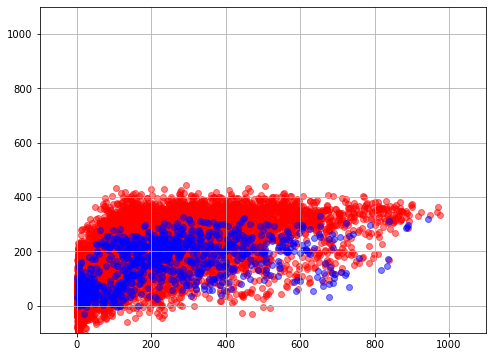

In [46]:
pylab.figure(figsize=(8, 6))
pylab.grid(True)
pylab.xlim(-100,1100)
pylab.ylim(-100,1100)
pylab.scatter(train_labels, grid_cv.best_estimator_.predict(train_data), alpha=0.5, color = 'red')
pylab.scatter(test_labels, grid_cv.best_estimator_.predict(test_data), alpha=0.5, color = 'blue')

### Другая модель

In [47]:
from sklearn.ensemble import RandomForestRegressor

In [48]:
regressor = RandomForestRegressor(random_state = 0, max_depth = 20, n_estimators = 50)

In [49]:
estimator = pipeline.Pipeline(steps = [       
    ('feature_processing', pipeline.FeatureUnion(transformer_list = [        
            #binary
            ('binary_variables_processing', preprocessing.FunctionTransformer(lambda data: data.iloc[:, binary_data_indices])), 
                    
            #numeric
            ('numeric_variables_processing', pipeline.Pipeline(steps = [
                ('selecting', preprocessing.FunctionTransformer(lambda data: data.iloc[:, numeric_data_indices])),
                ('scaling', preprocessing.StandardScaler(with_mean = 0, with_std = 1))            
                        ])),
        
            #categorical
            ('categorical_variables_processing', pipeline.Pipeline(steps = [
                ('selecting', preprocessing.FunctionTransformer(lambda data: data.iloc[:, categorical_data_indices])),
                ('hot_encoding', preprocessing.OneHotEncoder(handle_unknown = 'ignore'))            
                        ])),
        ])),
    ('model_fitting', regressor)
    ]
)

In [50]:
estimator.fit(train_data, train_labels)

Pipeline(steps=[('feature_processing',
                 FeatureUnion(transformer_list=[('binary_variables_processing',
                                                 FunctionTransformer(func=<function <lambda> at 0x0000013EE8050160>)),
                                                ('numeric_variables_processing',
                                                 Pipeline(steps=[('selecting',
                                                                  FunctionTransformer(func=<function <lambda> at 0x0000013EE83FAE50>)),
                                                                 ('scaling',
                                                                  StandardScaler(with_mean=0,
                                                                                 with_std=1))])),
                                                ('categorical_variables_processing',
                                                 Pipeline(steps=[('selecting',
                                 

In [51]:
metrics.mean_absolute_error(test_labels, estimator.predict(test_data))

79.49758619912876

In [52]:
test_labels[:10]

array([525, 835, 355, 222, 228, 325, 328, 308, 346, 446], dtype=int64)

In [53]:
estimator.predict(test_data)[:10]

array([409.565     , 505.56      , 256.06066667, 165.6502619 ,
       205.82474784, 265.91960439, 254.61615818, 317.85774486,
       280.98963263, 434.51333333])

Text(0.5, 1.0, 'random forest model')

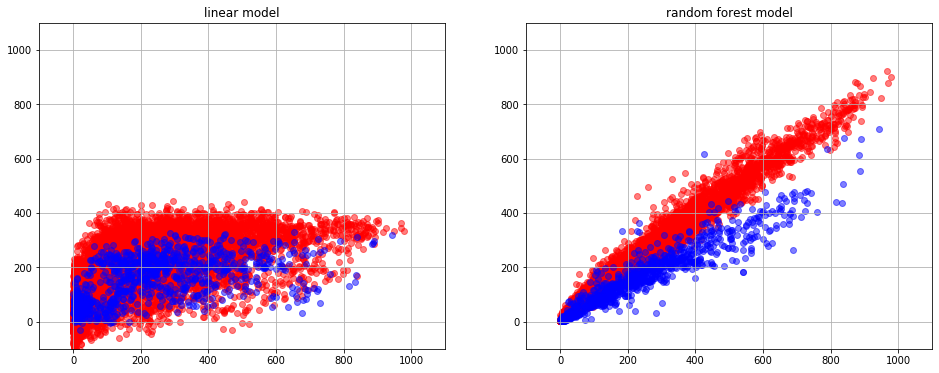

In [44]:
pylab.figure(figsize=(16, 6))

pylab.subplot(1,2,1)
pylab.grid(True)
pylab.xlim(-100,1100)
pylab.ylim(-100,1100)
pylab.scatter(train_labels, grid_cv.best_estimator_.predict(train_data), alpha=0.5, color = 'red')
pylab.scatter(test_labels, grid_cv.best_estimator_.predict(test_data), alpha=0.5, color = 'blue')
pylab.title('linear model')

pylab.subplot(1,2,2)
pylab.grid(True)
pylab.xlim(-100,1100)
pylab.ylim(-100,1100)
pylab.scatter(train_labels, estimator.predict(train_data), alpha=0.5, color = 'red')
pylab.scatter(test_labels, estimator.predict(test_data), alpha=0.5, color = 'blue')
pylab.title('random forest model')